In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seatsvotes

/home/lw17329/anaconda/envs/ana/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [4]:
canada = seatsvotes.data.canada()
house6311 = seatsvotes.data.icspr6311()

AttributeError: module 'seatsvotes.data' has no attribute 'icspr6311'

In [4]:
house6311.columns = ['year', 'idx', 'state', 'dist', 'inc', 'vote_share', 'turnout', 'south']

In [5]:
house6311.turnout.replace(house6311.turnout.min(), np.nan, inplace=True)

In [6]:
house6311 = house6311.dropna(axis=0, subset=['turnout'])

In [7]:
canada.columns = ['name', 'turnout', 'liberal', 
                  'progcons', 'ndp', 'socialcredit']

In [8]:
canada.index = canada.name
canada = canada.drop('name', axis=1)

In [9]:
canada['year'] = 1979

In [10]:
gm = seatsvotes.GaussianMixture(house6311).fit(n_components=3)

In [11]:
for_linzer = house6311[['turnout', 'vote_share', 'year']].copy()

In [12]:
for_linzer['dem_share'] = for_linzer.vote_share
for_linzer['rep_share'] = 1 - for_linzer.vote_share

In [13]:
for_linzer.drop('vote_share', axis=1, inplace=True)

In [14]:
for_linzer.head()

,turnout,year,dem_share,rep_share
0,38482.0,1896,0.282184,0.717816
1,58261.0,1896,0.383052,0.616948
2,22934.0,1896,0.334220,0.665780
3,46381.0,1896,0.338997,0.661003
4,28119.0,1896,0.312600,0.687400


In [15]:
lzhouse1990 =(seatsvotes.GaussianMixture(for_linzer
                            .query('year==1990')
                            .drop('year', axis=1))
                .fit(n_components=3))

In [16]:
mixelex = lzhouse1990.simulate_elections(1000)

In [17]:
house6311['geom_id'] = (house6311.state.apply(lambda x: str(x).rjust(2, '0'))
                        + house6311.dist.apply(lambda x: str(x).rjust(2, '0')))

In [18]:
house6311[['inc_r', 'no_inc', 'inc_d']] = pd.get_dummies(house6311.inc)

In [20]:
jihouse = seatsvotes.SuccessiveOLS(house6311,
                        covariate_columns=['inc_r', 'no_inc', 'inc_d'],
                        share_column='vote_share', 
                        weight_column='turnout',
                        district_id='dist')

/home/lw17329/Dropbox/dissert/dev/seatsvotes/seatsvotes/gelmanking/utils.py:31: UserWarning: computing redistricting from years vector
  warn('computing redistricting from years vector')
/home/lw17329/anaconda/envs/ana/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/home/lw17329/Dropbox/dissert/dev/seatsvotes/seatsvotes/mixins.py:209: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  self.long = pd.concat(self.wide, axis=0)


In [22]:
test = jihouse.simulate_elections(10)

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


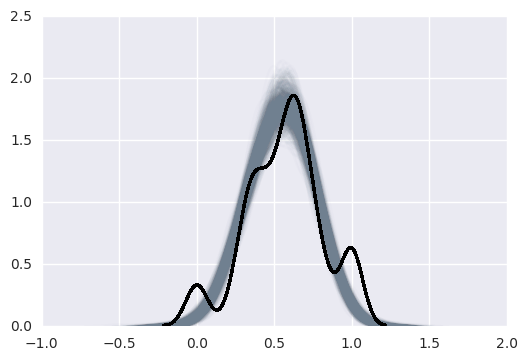

In [21]:
for elex in jielex:
    sns.kdeplot(elex, color='slategrey', alpha=.02)
    sns.kdeplot(house6311.query('year==1990').vote_share.values, color='k')

/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/ljw/anaconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


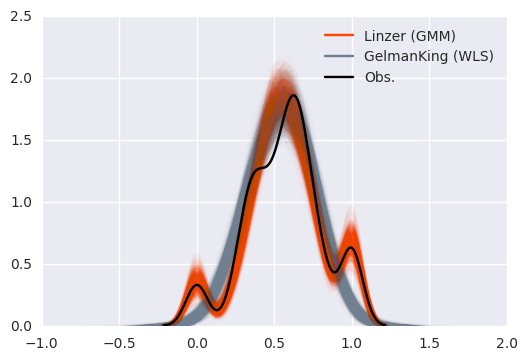

In [22]:
for i,mixsim in mixelex.groupby(level=0):
    linsim = jielex[i]
    sns.kdeplot(mixsim['dem_share'].values, 
                color='orangered', alpha=.02)
    sns.kdeplot(linsim, color='slategrey', alpha=.02)
sns.kdeplot(np.asarray([0]*3), color='orangered', label='Linzer (GMM)')
sns.kdeplot(np.asarray([0]*3), color='slategrey', label='GelmanKing (WLS)')
sns.kdeplot(house6311.query('year==1990')['vote_share'], color='k', label='Obs.')
plt.legend()
plt.show()